In [43]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np

In [44]:
def sinkhorn_with_polarization(C, a, b, P, P_max, epsilon, lambda_p, dual_lr=0.1, precision=1e-5, max_iter=5000):
    """
    Sinkhorn algorithm with polarization constraint.

    Args:
        C (ndarray): Cost matrix.
        a (ndarray): Marginal distribution for rows (shape: (n, 1)).
        b (ndarray): Marginal distribution for columns (shape: (m, 1)).
        P (ndarray): Polarization scores for columns (shape: (m,)).
        P_max (float): Maximum allowable polarization.
        epsilon (float): Entropic regularization parameter.
        lambda_p (float): Polarization penalty weight.
        dual_lr (float): Learning rate for dual variable (kappa).
        precision (float): Convergence threshold.
        max_iter (int): Maximum number of iterations.

    Returns:
        P_opt (ndarray): Optimal transport plan.
        polarization_history (list): Evolution of polarization over iterations.
        kappa_history (list): Evolution of dual variable kappa over iterations.
        objective_history (list): Evolution of objective function over iterations.
    """
    n, m = C.shape
    # Initialize variables
    kappa = 0.0  # Dual variable for polarization constraint
    u = np.ones((n, 1))  # Row scaling factors
    v = np.ones((m, 1))  # Column scaling factors
    polarization_history = []
    kappa_history = []
    objective_history = []
    objective_history_engagement = []
    
    # Compute initial adjusted cost matrix and kernel
    C_adjusted = C + lambda_p * P[np.newaxis, :] + kappa * P[np.newaxis, :]
    # Cap the exponent to prevent numerical issues
    max_exponent = 700  # np.exp(700) is close to the maximum float64 value
    exponent = -C_adjusted / epsilon
    exponent = np.clip(exponent, -max_exponent, max_exponent)
    K = np.exp(exponent)

    for iteration in range(max_iter):
        # Update scaling factors using the current kernel
        for _ in range(50):  # Inner loop for Sinkhorn iterations
            u_prev = u.copy()
            v_prev = v.copy()

            u = a / np.maximum(K @ v, 1e-100)
            v = b / np.maximum(K.T @ u, 1e-100)

            # Convergence check for scaling factors
            err_u = np.linalg.norm(u - u_prev)
            err_v = np.linalg.norm(v - v_prev)
            if err_u < precision and err_v < precision:
                break

        # Compute transport plan
        P_opt = np.diagflat(u.flatten()) @ K @ np.diagflat(v.flatten())

        # Compute total polarization
        total_polarization = np.sum(P_opt * P[np.newaxis, :])
        polarization_history.append(total_polarization)

        # Compute objective function value
        objective = -np.sum(P_opt * C) + lambda_p * np.sum(P_opt * P[np.newaxis, :]) - epsilon * np.sum(P_opt * (np.log(P_opt + 1e-100) - 1))
        engagement = -np.sum(P_opt * C)
        objective_history.append(objective)
        objective_history_engagement.append(engagement)


        # Store dual variable history
        kappa_history.append(kappa)

        # Check polarization constraint
        if total_polarization > P_max + precision:
            # Update dual variable for polarization constraint
            polarization_violation = total_polarization - P_max
            kappa += dual_lr * polarization_violation
            kappa = max(kappa, 0.0)  # Ensure kappa remains non-negative

            # Update adjusted cost matrix and kernel with new kappa
            C_adjusted = C + lambda_p * P[np.newaxis, :] + kappa * P[np.newaxis, :]
            exponent = -C_adjusted / epsilon
            exponent = np.clip(exponent, -max_exponent, max_exponent)
            K = np.exp(exponent)
        else:
            # Polarization constraint satisfied
            if err_u < precision and err_v < precision:
                print(f"Converged at iteration {iteration} with total_polarization = {total_polarization:.4f}.")
                break

    else:
        print(f"Reached maximum iterations ({max_iter}) with total_polarization = {total_polarization:.4f}.")

    return P_opt, polarization_history, kappa_history, objective_history, objective_history_engagement

In [45]:
# Example setup and testing
if __name__ == "__main__":
    n_users = 500
    n_content = 400
    np.random.seed(42)

    # Generate distributions and polarization scores
    a = np.random.rand(n_users, 1)
    a /= a.sum()
    b = np.random.rand(n_content, 1)
    b /= b.sum()
    C = np.random.rand(n_users, n_content)  # Cost matrix
    P = np.random.rand(n_content)  # Polarization scores

    # Constraints and regularization
    P_max = 0.2  # Adjusted P_max to ensure feasibility
    epsilon = 0.1  # Entropic regularization parameter
    lambda_p = 1.0  # Polarization penalty weight
    dual_lr = 0.5  # Increased learning rate

    # Run the modified Sinkhorn algorithm
    P_opt, polarization_history, kappa_history, objective_history, objective_history_engagement = sinkhorn_with_polarization(
        C, a, b, P, P_max, epsilon, lambda_p, dual_lr=dual_lr, precision=1e-6, max_iter=5000
    )

    # Print the results
    total_polarization = np.sum(P_opt * P[np.newaxis, :])
    print("Optimal transport plan computed.")
    print(f"Total polarization: {total_polarization:.4f}")
    print(f"Total polarization constraint P_max: {P_max}")
    print(f"Sum over users (should equal a): {np.allclose(P_opt.sum(axis=1, keepdims=True), a, atol=1e-6)}")
    print(f"Sum over content (should equal b): {np.allclose(P_opt.sum(axis=0, keepdims=True).T, b, atol=1e-6)}")


Converged at iteration 4030 with total_polarization = 0.2000.
Optimal transport plan computed.
Total polarization: 0.2000
Total polarization constraint P_max: 0.2
Sum over users (should equal a): False
Sum over content (should equal b): False


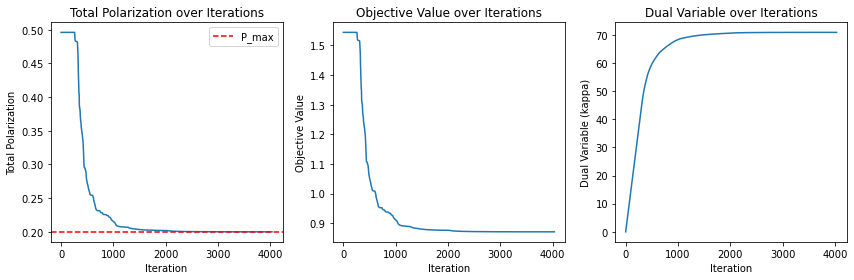

In [46]:
# Plotting the evolution of polarization and objective value
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(polarization_history)
plt.axhline(P_max, color='r', linestyle='--', label='P_max')
plt.xlabel('Iteration')
plt.ylabel('Total Polarization')
plt.title('Total Polarization over Iterations')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(objective_history)
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.title('Objective Value over Iterations')

plt.subplot(1, 3, 3)
plt.plot(kappa_history)
plt.xlabel('Iteration')
plt.ylabel('Dual Variable (kappa)')
plt.title('Dual Variable over Iterations')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Objective Value over Iterations')

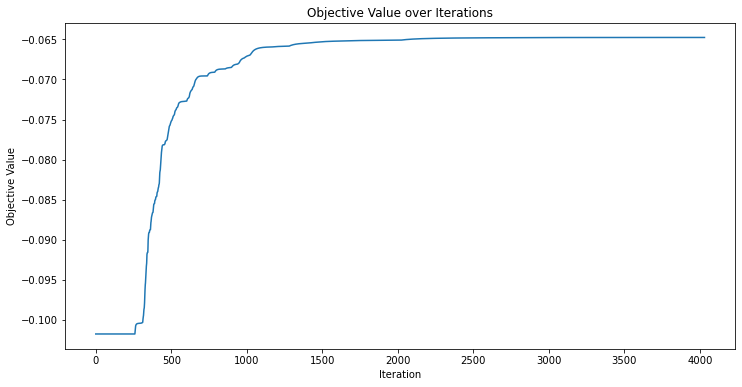

In [47]:

plt.figure(figsize=(12, 6))

plt.plot(objective_history_engagement)
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.title('Objective Value over Iterations')
